In [5]:
# %%

%load_ext autoreload
%autoreload 2


# %%
import torch
import time
import plotly.express as px
import matplotlib.pyplot as plt

from task_evaluation import TaskEvaluation
from data.ioi_dataset import gen_templated_prompts
from data.greater_than_dataset import generate_greater_than_dataset
from circuit_discovery import CircuitDiscovery, only_feature
from circuit_lens import CircuitComponent
from plotly_utils import *
from data.ioi_dataset import IOI_GROUND_TRUTH_HEADS
from data.greater_than_dataset import GT_GROUND_TRUTH_HEADS
from memory import get_gpu_memory
from sklearn import metrics
from tqdm import trange

from utils import get_attn_head_roc


# %%
torch.set_grad_enabled(False)
get_gpu_memory()
# %%
dataset_prompts = gen_templated_prompts(template_idex=1, N=500)
dataset_gt = generate_greater_than_dataset(N=500)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
No CUDA-capable device is detected
torch.Size([500, 13]) torch.Size([500])


In [6]:



# dataset_prompts = generate_greater_than_dataset(N=100)


# %%

def component_filter(component: str):
    return component in [
        CircuitComponent.Z_FEATURE,
        CircuitComponent.MLP_FEATURE,
        CircuitComponent.ATTN_HEAD,
        CircuitComponent.UNEMBED,
        # CircuitComponent.UNEMBED_AT_TOKEN,
        CircuitComponent.EMBED,
        CircuitComponent.POS_EMBED,
        # CircuitComponent.BIAS_O,
        CircuitComponent.Z_SAE_ERROR,
        # CircuitComponent.Z_SAE_BIAS,
        # CircuitComponent.TRANSCODER_ERROR,
        # CircuitComponent.TRANSCODER_BIAS,
    ]


pass_based = True

passes = 5
node_contributors = 1
first_pass_minimal = True

sub_passes = 3
do_sub_pass = True #False
layer_thres = 9
minimal = True


num_greedy_passes = 20
k = 1
N = 30

thres = 4


# # Danny and Charlie... Charlie gave shit to Danny
# # Danny and Charlie... Charlie gave shit to Charlie
# # Danny and Charlie... Danny gave shit to Danny
# #

def strategy(cd: CircuitDiscovery):
    if pass_based:
        for _ in range(passes):
            cd.add_greedy_pass(contributors_per_node=node_contributors, minimal=first_pass_minimal)

            if do_sub_pass:
                for _ in range(sub_passes):
                    cd.add_greedy_pass_against_all_existing_nodes(contributors_per_node=node_contributors, skip_z_features=True, layer_threshold=layer_thres, minimal=minimal)
    else:
        for _ in range(num_greedy_passes):
            cd.greedily_add_top_contributors(k=k, reciever_threshold=thres)



task_eval = TaskEvaluation(prompts=dataset_prompts, circuit_discovery_strategy=strategy, allowed_components_filter=component_filter)

torch.Size([20, 50257]) torch.Size([20, 2])
torch.Size([20, 50257]) torch.Size([20, 2])
hbi [[5, 8], [9, 6], [0, 1], [7, 9], [9, 9], [2, 2], [8, 10], [7, 3], [9, 7], [10, 0], [3, 0], [10, 2], [10, 7], [11, 10], [8, 6], [10, 6], [11, 3], [11, 2], [4, 11], [6, 9], [10, 10], [0, 10], [11, 9], [10, 1], [5, 5], [5, 9], [6, 4], [8, 7], [8, 5], [6, 5], [11, 5], [2, 3], [6, 7], [3, 7], [2, 9], [4, 3], [3, 3], [8, 8], [3, 4], [4, 8], [8, 0], [1, 5], [9, 5], [0, 2], [9, 10], [5, 6], [0, 3], [0, 6], [2, 6], [11, 7], [2, 8], [9, 1], [1, 8], [5, 11], [5, 4], [3, 11], [0, 0], [10, 8], [1, 4], [11, 1], [1, 6], [4, 4], [10, 3], [8, 3], [4, 5], [6, 1], [6, 6], [6, 10], [2, 4], [0, 5], [7, 8], [10, 9], [8, 11], [0, 4], [6, 2], [3, 6], [2, 0], [7, 1], [0, 9], [11, 11], [7, 7], [0, 11], [5, 1], [3, 10], [6, 3], [4, 9], [4, 2], [2, 1], [6, 8], [1, 1], [5, 10], [5, 0], [7, 6], [1, 11], [6, 11], [8, 2], [2, 11], [2, 10], [7, 10], [3, 2], [5, 3], [8, 1], [4, 10], [11, 4], [7, 2], [1, 3], [9, 3], [4, 0], [1, 1

100%|██████████| 10/10 [01:04<00:00,  6.43s/it]


torch.Size([20, 50257]) torch.Size([20, 2])
torch.Size([20, 50257]) torch.Size([20, 2])
hbi [[10, 1], [0, 1], [5, 5], [0, 3], [9, 11], [0, 5], [0, 6], [0, 7], [9, 0], [9, 1], [9, 10], [6, 8], [10, 7], [9, 9], [8, 7], [8, 6], [7, 0], [3, 8], [7, 4], [7, 5], [2, 8], [9, 3], [1, 10], [2, 7], [2, 0], [9, 7], [2, 2], [9, 6], [3, 0], [5, 0], [10, 6], [10, 9], [4, 11], [10, 10], [10, 0], [10, 3], [5, 1], [4, 3], [2, 9], [6, 1], [10, 4], [10, 2], [9, 8], [3, 7], [1, 5], [6, 0], [9, 5], [1, 11], [1, 1], [6, 9], [4, 7], [0, 4], [10, 11], [9, 4], [3, 6], [9, 2], [10, 5], [6, 4], [7, 3], [8, 5], [0, 10], [6, 11], [5, 2], [1, 0], [5, 7], [11, 10], [8, 3], [10, 8], [5, 8], [8, 4], [5, 10], [0, 11], [3, 3], [8, 10], [7, 9], [1, 2], [5, 4], [6, 5], [11, 7], [11, 5], [2, 3], [2, 4], [4, 5], [3, 11], [3, 10], [7, 1], [11, 1], [3, 4], [7, 2], [2, 10], [5, 6], [2, 5], [7, 8], [4, 0], [4, 1], [4, 4], [2, 1], [11, 3], [11, 4], [5, 9], [11, 6], [6, 6], [11, 8], [4, 9], [0, 9], [11, 9], [11, 2], [8, 11], [8, 

  0%|          | 0/20 [00:00<?, ?it/s]

torch.Size([20, 50257]) torch.Size([20, 2])
torch.Size([20, 50257]) torch.Size([20, 2])
hbi [[11, 10], [9, 5], [6, 2], [3, 3], [8, 9], [5, 9], [9, 4], [9, 11], [8, 8], [1, 5], [0, 4], [9, 1], [3, 1], [0, 3], [0, 2], [8, 4], [5, 8], [11, 6], [5, 3], [8, 1], [1, 10], [10, 5], [10, 7], [7, 10], [10, 6], [0, 0], [8, 0], [2, 6], [1, 6], [6, 10], [10, 4], [2, 0], [5, 0], [7, 6], [9, 9], [6, 0], [10, 0], [8, 7], [1, 7], [2, 2], [10, 3], [8, 3], [10, 2], [1, 11], [9, 2], [2, 4], [5, 6], [3, 2], [11, 7], [7, 7], [11, 1], [1, 9], [6, 1], [11, 2], [5, 4], [1, 1], [4, 11], [6, 9], [9, 0], [10, 10], [4, 2], [4, 8], [4, 1], [3, 6], [6, 5], [3, 10], [7, 0], [5, 7], [0, 1], [10, 8], [9, 6], [3, 9], [0, 8], [2, 10], [10, 11], [6, 3], [0, 9], [7, 9], [9, 10], [8, 5], [5, 10], [7, 2], [0, 5], [6, 4], [6, 6], [4, 10], [3, 5], [2, 7], [1, 3], [7, 3], [11, 8], [6, 7], [4, 4], [0, 6], [1, 4], [5, 2], [6, 8], [2, 8], [3, 7], [7, 1], [10, 9], [11, 9], [5, 11], [2, 11], [4, 3], [11, 11], [4, 6], [11, 4], [3, 11

  5%|▌         | 1/20 [00:06<02:01,  6.39s/it]

torch.Size([20, 50257]) torch.Size([20, 2])
torch.Size([20, 50257]) torch.Size([20, 2])
hbi [[6, 7], [1, 1], [4, 10], [0, 3], [4, 0], [4, 6], [6, 1], [3, 1], [9, 2], [6, 2], [0, 11], [0, 7], [0, 1], [11, 1], [3, 5], [9, 3], [5, 2], [7, 4], [5, 9], [5, 8], [6, 5], [0, 8], [0, 5], [8, 3], [5, 7], [10, 2], [4, 8], [3, 7], [7, 9], [10, 1], [1, 4], [10, 3], [9, 4], [9, 11], [2, 8], [7, 11], [9, 5], [9, 7], [0, 10], [1, 2], [4, 5], [4, 7], [5, 1], [7, 0], [6, 8], [0, 4], [10, 0], [5, 3], [1, 3], [5, 11], [5, 10], [9, 0], [4, 11], [2, 3], [11, 4], [4, 9], [8, 10], [10, 9], [3, 0], [2, 4], [7, 6], [6, 11], [3, 10], [1, 7], [1, 8], [5, 0], [6, 3], [7, 2], [2, 11], [10, 5], [8, 7], [10, 4], [8, 5], [10, 11], [10, 7], [11, 10], [2, 6], [2, 1], [8, 0], [6, 6], [8, 8], [9, 1], [11, 6], [11, 2], [11, 3], [2, 9], [2, 5], [1, 9], [6, 0], [10, 8], [1, 0], [3, 9], [6, 10], [2, 7], [9, 8], [7, 8], [9, 6], [3, 6], [11, 5], [0, 2], [7, 5], [9, 9], [6, 4], [1, 6], [8, 9], [3, 2], [10, 6], [8, 1], [2, 10], [

 10%|█         | 2/20 [00:12<01:49,  6.10s/it]

torch.Size([20, 50257]) torch.Size([20, 2])
torch.Size([20, 50257]) torch.Size([20, 2])
hbi [[5, 3], [0, 0], [1, 7], [4, 8], [7, 0], [8, 1], [1, 6], [0, 8], [2, 6], [5, 2], [7, 3], [9, 11], [3, 8], [4, 0], [4, 1], [0, 4], [3, 9], [8, 10], [5, 7], [7, 11], [7, 7], [1, 2], [4, 4], [9, 10], [11, 2], [1, 9], [3, 3], [8, 8], [10, 3], [8, 3], [10, 4], [3, 6], [2, 3], [2, 4], [0, 1], [6, 2], [7, 10], [6, 11], [3, 11], [4, 11], [11, 5], [5, 5], [10, 5], [6, 9], [1, 4], [2, 11], [4, 2], [6, 1], [5, 10], [4, 5], [9, 6], [10, 0], [6, 10], [0, 9], [1, 10], [11, 8], [1, 11], [3, 4], [7, 6], [11, 4], [9, 0], [0, 6], [1, 8], [10, 10], [2, 9], [1, 1], [5, 4], [10, 8], [7, 9], [8, 0], [4, 6], [9, 4], [4, 3], [2, 2], [2, 0], [10, 9], [6, 4], [4, 10], [5, 6], [4, 7], [8, 4], [3, 10], [7, 8], [3, 1], [10, 6], [9, 1], [1, 3], [6, 0], [11, 1], [10, 1], [8, 5], [8, 6], [7, 2], [2, 1], [3, 7], [11, 7], [5, 8], [9, 7], [3, 0], [2, 8], [2, 10], [3, 2], [0, 2], [0, 11], [0, 5], [8, 11], [6, 8], [10, 2], [4, 9], 

 15%|█▌        | 3/20 [00:18<01:42,  6.02s/it]

torch.Size([20, 50257]) torch.Size([20, 2])
torch.Size([20, 50257]) torch.Size([20, 2])
hbi [[3, 3], [2, 0], [5, 2], [0, 5], [6, 0], [8, 2], [9, 11], [7, 5], [4, 1], [11, 9], [0, 2], [3, 7], [6, 9], [10, 3], [3, 6], [8, 8], [0, 8], [3, 5], [3, 2], [7, 6], [6, 6], [5, 7], [6, 1], [11, 11], [11, 3], [2, 2], [0, 4], [8, 3], [9, 8], [2, 1], [7, 11], [1, 11], [3, 9], [9, 5], [0, 1], [6, 10], [2, 11], [0, 6], [10, 0], [7, 9], [8, 11], [9, 0], [7, 1], [11, 6], [5, 9], [4, 6], [4, 0], [1, 7], [9, 10], [8, 6], [2, 10], [6, 11], [7, 10], [1, 5], [4, 4], [2, 8], [10, 4], [8, 7], [10, 2], [2, 7], [7, 2], [9, 2], [10, 11], [9, 3], [11, 7], [8, 1], [1, 9], [2, 3], [3, 11], [7, 4], [4, 9], [0, 0], [11, 8], [4, 10], [9, 4], [10, 5], [4, 11], [1, 0], [6, 7], [5, 0], [3, 4], [3, 8], [1, 8], [2, 4], [11, 2], [5, 3], [11, 1], [5, 4], [4, 2], [1, 10], [5, 10], [0, 9], [11, 4], [7, 7], [1, 3], [3, 1], [5, 6], [5, 11], [11, 0], [2, 9], [8, 5], [9, 1], [7, 3], [8, 9], [11, 5], [1, 1], [10, 6], [6, 5], [4, 8],

 20%|██        | 4/20 [00:24<01:36,  6.01s/it]

torch.Size([20, 50257]) torch.Size([20, 2])
torch.Size([20, 50257]) torch.Size([20, 2])
hbi [[7, 7], [2, 5], [8, 2], [4, 10], [4, 11], [4, 8], [9, 1], [5, 3], [10, 9], [3, 5], [0, 7], [11, 4], [6, 3], [3, 6], [2, 4], [2, 6], [9, 9], [3, 11], [2, 7], [11, 2], [9, 7], [11, 9], [11, 3], [9, 5], [6, 5], [5, 0], [1, 8], [10, 11], [7, 8], [10, 3], [3, 7], [3, 10], [5, 11], [10, 4], [9, 3], [1, 3], [11, 10], [8, 4], [4, 3], [9, 6], [7, 3], [6, 4], [5, 2], [3, 4], [10, 2], [6, 11], [0, 1], [8, 1], [9, 11], [10, 1], [10, 6], [2, 11], [7, 9], [4, 0], [10, 0], [5, 9], [0, 4], [6, 8], [9, 4], [10, 5], [1, 1], [6, 9], [0, 2], [9, 2], [0, 8], [10, 10], [11, 8], [3, 0], [2, 1], [0, 5], [6, 1], [0, 11], [5, 1], [1, 4], [11, 0], [7, 0], [7, 1], [7, 2], [8, 7], [0, 9], [4, 4], [1, 5], [8, 5], [9, 0], [8, 6], [5, 5], [4, 7], [0, 3], [0, 10], [1, 0], [11, 5], [2, 10], [2, 3], [5, 8], [3, 8], [3, 2], [8, 11], [7, 5], [6, 0], [6, 2], [7, 10], [7, 4], [0, 6], [11, 6], [8, 3], [4, 9], [8, 0], [2, 8], [4, 5], 

 25%|██▌       | 5/20 [00:30<01:31,  6.10s/it]

torch.Size([20, 50257]) torch.Size([20, 2])
torch.Size([20, 50257]) torch.Size([20, 2])
hbi [[11, 11], [7, 2], [10, 7], [1, 3], [4, 9], [6, 7], [3, 11], [8, 1], [9, 9], [2, 10], [7, 7], [5, 8], [1, 4], [10, 10], [4, 4], [9, 11], [2, 11], [1, 9], [11, 5], [11, 2], [6, 11], [7, 11], [3, 9], [0, 4], [8, 9], [5, 3], [5, 0], [10, 11], [11, 10], [9, 3], [3, 5], [4, 11], [0, 2], [1, 6], [7, 6], [9, 5], [8, 11], [8, 7], [7, 5], [10, 9], [0, 5], [8, 0], [9, 6], [1, 5], [10, 1], [6, 10], [0, 10], [6, 2], [5, 9], [3, 6], [4, 10], [8, 3], [4, 6], [2, 3], [8, 5], [0, 11], [10, 2], [8, 6], [5, 7], [7, 9], [5, 5], [3, 10], [9, 4], [1, 11], [7, 0], [10, 4], [6, 4], [4, 8], [3, 1], [6, 6], [7, 4], [11, 8], [2, 8], [4, 1], [5, 1], [2, 5], [1, 7], [0, 6], [9, 2], [4, 0], [6, 0], [2, 0], [9, 8], [3, 8], [6, 9], [11, 0], [6, 8], [6, 3], [8, 2], [8, 4], [1, 8], [2, 7], [10, 3], [3, 4], [11, 3], [11, 9], [0, 0], [7, 8], [5, 6], [11, 4], [4, 2], [7, 1], [3, 0], [11, 7], [5, 10], [10, 6], [11, 1], [0, 1], [0, 

 30%|███       | 6/20 [00:36<01:26,  6.18s/it]

torch.Size([20, 50257]) torch.Size([20, 2])
torch.Size([20, 50257]) torch.Size([20, 2])
hbi [[3, 6], [0, 11], [1, 10], [3, 5], [8, 6], [1, 1], [6, 11], [0, 3], [7, 10], [9, 8], [6, 2], [10, 11], [7, 0], [10, 4], [7, 5], [4, 2], [8, 9], [10, 1], [6, 8], [1, 4], [9, 9], [2, 0], [6, 1], [11, 11], [9, 7], [6, 6], [0, 0], [4, 4], [1, 6], [9, 3], [11, 3], [10, 5], [0, 1], [2, 9], [7, 2], [7, 4], [10, 0], [10, 2], [4, 8], [3, 2], [10, 8], [11, 9], [10, 3], [5, 3], [6, 9], [10, 10], [5, 6], [7, 3], [6, 5], [11, 0], [9, 6], [10, 9], [1, 7], [2, 6], [7, 11], [5, 2], [8, 11], [8, 1], [8, 0], [8, 10], [2, 10], [11, 7], [3, 9], [7, 6], [9, 11], [4, 10], [1, 2], [5, 9], [2, 3], [3, 11], [3, 8], [6, 3], [9, 1], [3, 7], [1, 9], [5, 0], [1, 8], [11, 4], [0, 6], [6, 0], [3, 10], [0, 2], [9, 0], [11, 2], [2, 2], [6, 4], [2, 5], [8, 8], [4, 5], [5, 1], [3, 0], [5, 5], [5, 10], [5, 11], [0, 8], [1, 11], [8, 4], [3, 4], [0, 10], [11, 1], [7, 7], [8, 5], [11, 8], [9, 5], [5, 7], [6, 7], [3, 3], [6, 10], [4, 

 35%|███▌      | 7/20 [00:42<01:20,  6.16s/it]

torch.Size([20, 50257]) torch.Size([20, 2])
torch.Size([20, 50257]) torch.Size([20, 2])
hbi [[10, 11], [10, 8], [8, 4], [3, 11], [0, 3], [7, 0], [4, 7], [8, 11], [2, 1], [6, 8], [0, 11], [11, 8], [3, 3], [10, 0], [0, 8], [1, 7], [5, 10], [8, 9], [4, 6], [5, 7], [8, 10], [11, 7], [0, 0], [1, 4], [4, 11], [6, 0], [6, 7], [10, 7], [7, 9], [7, 10], [7, 11], [2, 10], [7, 6], [0, 9], [9, 5], [2, 3], [2, 11], [9, 1], [11, 4], [6, 5], [7, 2], [8, 7], [2, 6], [3, 2], [10, 6], [6, 6], [11, 11], [4, 4], [5, 3], [1, 1], [2, 2], [5, 1], [10, 9], [4, 0], [3, 6], [1, 10], [6, 1], [7, 7], [5, 5], [6, 2], [2, 9], [7, 8], [0, 2], [10, 3], [6, 10], [1, 9], [3, 7], [9, 8], [8, 6], [10, 10], [5, 2], [10, 4], [2, 5], [4, 1], [9, 9], [11, 6], [8, 8], [5, 0], [9, 3], [2, 0], [9, 7], [5, 8], [4, 2], [6, 9], [2, 7], [10, 1], [4, 10], [6, 4], [8, 1], [1, 2], [1, 11], [3, 9], [11, 2], [7, 4], [4, 5], [4, 3], [1, 8], [3, 4], [1, 5], [11, 3], [11, 5], [4, 8], [10, 2], [6, 11], [1, 6], [2, 4], [1, 3], [3, 1], [7, 5]

 40%|████      | 8/20 [00:49<01:13,  6.15s/it]

torch.Size([20, 50257]) torch.Size([20, 2])
torch.Size([20, 50257]) torch.Size([20, 2])
hbi [[0, 9], [1, 10], [4, 3], [8, 3], [2, 4], [5, 1], [4, 9], [10, 8], [7, 6], [0, 2], [1, 11], [11, 3], [0, 4], [5, 6], [0, 5], [9, 7], [11, 7], [10, 2], [1, 8], [6, 8], [1, 2], [0, 3], [5, 2], [3, 9], [10, 6], [9, 11], [11, 6], [2, 0], [8, 7], [9, 0], [2, 5], [0, 8], [9, 6], [10, 10], [5, 7], [4, 1], [6, 2], [11, 9], [8, 9], [8, 1], [10, 7], [0, 11], [6, 0], [3, 0], [4, 5], [1, 6], [5, 3], [6, 9], [8, 0], [9, 1], [11, 0], [2, 6], [9, 8], [4, 7], [2, 10], [9, 2], [10, 5], [3, 10], [2, 9], [0, 7], [7, 9], [1, 5], [3, 2], [7, 11], [4, 6], [1, 4], [0, 1], [3, 11], [5, 10], [5, 8], [8, 10], [10, 11], [3, 3], [1, 7], [8, 6], [7, 5], [7, 8], [10, 3], [5, 0], [6, 11], [1, 0], [4, 0], [3, 1], [5, 4], [11, 10], [0, 0], [3, 7], [1, 1], [2, 11], [2, 8], [7, 1], [8, 5], [10, 1], [6, 10], [7, 4], [11, 5], [6, 3], [2, 7], [6, 7], [3, 5], [6, 1], [8, 4], [7, 7], [9, 10], [5, 11], [11, 1], [4, 11], [8, 2], [3, 8],

 45%|████▌     | 9/20 [00:55<01:08,  6.21s/it]

torch.Size([20, 50257]) torch.Size([20, 2])
torch.Size([20, 50257]) torch.Size([20, 2])
hbi [[1, 9], [7, 7], [0, 6], [6, 0], [11, 2], [0, 9], [2, 0], [2, 10], [7, 5], [3, 10], [4, 3], [7, 9], [3, 0], [11, 0], [6, 10], [11, 7], [7, 2], [11, 5], [0, 2], [5, 6], [4, 1], [8, 0], [7, 10], [2, 4], [0, 10], [6, 4], [9, 9], [4, 7], [0, 11], [0, 1], [9, 8], [0, 5], [10, 0], [10, 10], [10, 1], [8, 2], [1, 6], [8, 11], [5, 0], [7, 8], [3, 8], [10, 7], [10, 3], [0, 4], [4, 0], [4, 10], [7, 11], [8, 4], [8, 10], [6, 2], [8, 8], [10, 4], [11, 9], [2, 2], [11, 8], [11, 10], [10, 9], [8, 5], [11, 6], [4, 6], [3, 9], [9, 0], [2, 3], [8, 3], [1, 4], [4, 8], [2, 11], [3, 3], [8, 9], [3, 11], [5, 5], [7, 0], [7, 3], [9, 6], [10, 5], [4, 5], [1, 11], [5, 3], [9, 4], [9, 5], [1, 5], [9, 3], [11, 4], [0, 7], [2, 6], [7, 1], [4, 4], [8, 6], [3, 4], [8, 1], [0, 3], [6, 1], [3, 2], [5, 11], [11, 3], [2, 1], [6, 8], [3, 7], [0, 0], [6, 11], [3, 5], [9, 1], [1, 10], [5, 1], [0, 8], [5, 9], [9, 10], [2, 8], [2, 9]

 50%|█████     | 10/20 [01:01<01:01,  6.13s/it]

torch.Size([20, 50257]) torch.Size([20, 2])
torch.Size([20, 50257]) torch.Size([20, 2])
hbi [[0, 11], [1, 4], [11, 9], [10, 11], [5, 2], [1, 11], [6, 9], [4, 9], [9, 2], [6, 3], [5, 6], [11, 1], [0, 4], [0, 9], [9, 3], [9, 9], [0, 1], [5, 10], [8, 1], [11, 10], [11, 11], [7, 10], [5, 9], [7, 5], [6, 6], [10, 6], [11, 6], [1, 8], [11, 7], [7, 1], [6, 2], [10, 0], [9, 8], [5, 0], [9, 6], [1, 9], [2, 8], [1, 3], [0, 6], [3, 3], [10, 9], [9, 7], [0, 10], [11, 0], [2, 3], [3, 7], [7, 8], [3, 1], [4, 10], [11, 8], [1, 6], [6, 10], [5, 4], [4, 2], [4, 11], [3, 0], [0, 3], [1, 2], [3, 6], [0, 7], [7, 4], [1, 5], [10, 3], [9, 11], [2, 11], [6, 5], [2, 7], [2, 10], [6, 4], [5, 3], [10, 2], [9, 4], [5, 11], [7, 2], [0, 0], [11, 4], [4, 7], [11, 5], [4, 5], [7, 0], [10, 5], [2, 6], [3, 10], [5, 7], [0, 5], [5, 1], [3, 9], [10, 7], [9, 5], [4, 4], [2, 2], [0, 8], [6, 11], [4, 0], [9, 0], [7, 3], [1, 0], [2, 0], [8, 5], [8, 4], [8, 6], [10, 1], [6, 8], [8, 11], [11, 3], [3, 4], [8, 7], [11, 2], [1, 

 55%|█████▌    | 11/20 [01:07<00:54,  6.07s/it]

torch.Size([20, 50257]) torch.Size([20, 2])
torch.Size([20, 50257]) torch.Size([20, 2])
hbi [[7, 2], [8, 10], [6, 2], [7, 6], [10, 4], [0, 0], [8, 3], [8, 4], [8, 9], [9, 3], [3, 9], [1, 10], [6, 9], [7, 4], [6, 10], [8, 6], [2, 9], [8, 1], [7, 0], [0, 1], [0, 9], [11, 6], [8, 2], [6, 5], [4, 5], [3, 0], [7, 3], [2, 10], [9, 10], [11, 3], [9, 6], [6, 7], [10, 11], [1, 9], [9, 1], [11, 2], [2, 4], [5, 10], [10, 7], [11, 11], [5, 9], [5, 2], [5, 11], [10, 9], [1, 2], [5, 8], [7, 5], [11, 9], [10, 1], [7, 11], [10, 2], [9, 4], [8, 8], [5, 6], [11, 5], [7, 7], [4, 2], [0, 7], [9, 5], [1, 8], [0, 10], [9, 0], [6, 3], [11, 4], [4, 11], [4, 8], [8, 0], [4, 0], [4, 3], [0, 5], [0, 2], [2, 1], [6, 0], [2, 0], [0, 8], [10, 0], [11, 10], [8, 11], [11, 8], [5, 1], [1, 4], [5, 4], [10, 6], [7, 10], [3, 8], [1, 3], [2, 6], [6, 1], [0, 6], [0, 11], [5, 3], [6, 11], [7, 9], [10, 8], [3, 1], [4, 4], [9, 9], [5, 7], [10, 10], [2, 3], [5, 5], [4, 9], [1, 11], [11, 0], [9, 11], [3, 2], [2, 5], [1, 0], [0,

 60%|██████    | 12/20 [01:13<00:48,  6.02s/it]

torch.Size([20, 50257]) torch.Size([20, 2])
torch.Size([20, 50257]) torch.Size([20, 2])
hbi [[9, 1], [5, 6], [11, 5], [8, 1], [6, 2], [8, 6], [0, 4], [10, 3], [4, 5], [7, 2], [11, 2], [9, 4], [3, 6], [10, 7], [2, 1], [2, 3], [7, 0], [3, 10], [10, 5], [1, 11], [11, 0], [3, 0], [10, 1], [6, 9], [0, 6], [2, 10], [4, 3], [5, 0], [4, 7], [7, 6], [3, 8], [9, 9], [9, 0], [2, 2], [0, 7], [5, 3], [4, 9], [4, 1], [2, 5], [2, 0], [1, 4], [2, 4], [8, 3], [11, 11], [9, 5], [0, 0], [0, 1], [5, 2], [7, 9], [5, 9], [11, 4], [6, 3], [3, 7], [1, 6], [8, 8], [1, 2], [5, 10], [0, 2], [10, 4], [1, 5], [10, 8], [1, 8], [7, 1], [4, 4], [7, 10], [10, 9], [4, 6], [10, 2], [10, 11], [8, 10], [9, 8], [4, 2], [7, 3], [5, 11], [11, 6], [5, 1], [6, 5], [3, 1], [6, 8], [0, 8], [11, 3], [10, 10], [0, 5], [7, 8], [8, 11], [0, 11], [1, 7], [3, 4], [10, 6], [1, 9], [11, 8], [9, 6], [2, 9], [5, 5], [7, 4], [6, 1], [6, 6], [3, 5], [8, 5], [6, 11], [10, 0], [6, 7], [9, 3], [4, 0], [3, 11], [8, 7], [0, 9], [1, 0], [8, 4], [

 65%|██████▌   | 13/20 [01:19<00:41,  5.99s/it]

torch.Size([20, 50257]) torch.Size([20, 2])
torch.Size([20, 50257]) torch.Size([20, 2])
hbi [[1, 9], [8, 2], [7, 10], [9, 9], [10, 5], [2, 0], [11, 11], [3, 10], [5, 7], [8, 6], [6, 5], [6, 0], [11, 2], [1, 3], [8, 4], [9, 6], [0, 3], [5, 2], [9, 10], [1, 6], [10, 11], [11, 6], [10, 3], [4, 3], [10, 4], [8, 8], [4, 5], [7, 2], [11, 7], [5, 6], [0, 0], [9, 5], [5, 9], [1, 5], [2, 7], [11, 1], [4, 0], [8, 1], [0, 6], [10, 6], [0, 10], [6, 9], [7, 1], [11, 0], [3, 9], [6, 11], [7, 4], [6, 8], [4, 1], [2, 5], [6, 10], [8, 3], [2, 2], [0, 4], [11, 5], [11, 9], [9, 1], [11, 3], [2, 8], [11, 4], [0, 2], [4, 6], [2, 11], [0, 5], [6, 3], [7, 3], [9, 4], [7, 11], [11, 8], [4, 2], [8, 5], [7, 6], [2, 6], [1, 0], [5, 5], [5, 8], [3, 11], [6, 4], [3, 8], [4, 9], [8, 0], [3, 1], [3, 5], [2, 4], [5, 3], [9, 3], [3, 0], [0, 9], [0, 1], [9, 8], [3, 2], [4, 10], [8, 9], [9, 2], [1, 1], [5, 11], [4, 8], [11, 10], [5, 10], [1, 11], [10, 0], [3, 3], [8, 11], [6, 6], [6, 7], [9, 7], [5, 0], [4, 4], [10, 7],

 70%|███████   | 14/20 [01:25<00:35,  5.98s/it]

torch.Size([20, 50257]) torch.Size([20, 2])
torch.Size([20, 50257]) torch.Size([20, 2])
hbi [[9, 0], [9, 6], [7, 4], [11, 8], [9, 4], [10, 0], [9, 5], [8, 8], [8, 4], [0, 2], [6, 10], [7, 7], [3, 7], [5, 9], [8, 2], [8, 0], [9, 7], [2, 4], [0, 8], [10, 2], [4, 7], [8, 3], [6, 11], [3, 5], [6, 4], [2, 3], [4, 8], [2, 10], [1, 7], [3, 0], [10, 1], [5, 11], [7, 9], [10, 7], [2, 0], [5, 3], [10, 4], [6, 2], [11, 9], [4, 3], [4, 2], [9, 11], [4, 11], [7, 2], [3, 4], [0, 10], [4, 1], [7, 8], [2, 7], [8, 6], [1, 8], [9, 10], [0, 0], [2, 11], [11, 7], [3, 6], [3, 1], [11, 6], [10, 11], [2, 5], [0, 1], [7, 10], [0, 3], [5, 1], [1, 5], [5, 6], [4, 9], [6, 9], [0, 6], [2, 2], [3, 8], [7, 3], [3, 3], [11, 1], [0, 7], [5, 8], [6, 8], [5, 10], [10, 3], [4, 0], [8, 11], [11, 4], [4, 4], [1, 10], [10, 5], [6, 7], [0, 5], [11, 3], [4, 6], [0, 11], [7, 5], [11, 0], [11, 5], [8, 5], [9, 9], [10, 6], [5, 2], [6, 5], [8, 10], [5, 5], [1, 1], [10, 8], [8, 9], [3, 9], [7, 1], [1, 4], [11, 10], [6, 1], [2, 6]

 75%|███████▌  | 15/20 [01:30<00:29,  5.96s/it]

torch.Size([20, 50257]) torch.Size([20, 2])
torch.Size([20, 50257]) torch.Size([20, 2])
hbi [[2, 1], [2, 6], [7, 5], [9, 10], [3, 1], [6, 11], [5, 0], [3, 9], [11, 4], [4, 1], [9, 11], [2, 0], [5, 2], [4, 4], [6, 6], [4, 6], [9, 8], [5, 6], [5, 3], [8, 10], [10, 5], [7, 1], [6, 4], [11, 7], [7, 6], [10, 9], [3, 5], [5, 5], [10, 10], [5, 1], [8, 7], [0, 5], [0, 6], [6, 0], [2, 4], [7, 10], [6, 7], [11, 1], [5, 10], [9, 3], [1, 11], [11, 2], [4, 10], [5, 7], [7, 3], [10, 1], [9, 6], [8, 9], [7, 8], [9, 7], [9, 0], [3, 10], [10, 7], [7, 2], [5, 4], [4, 11], [6, 10], [1, 8], [7, 11], [2, 10], [0, 11], [1, 6], [10, 2], [4, 7], [6, 8], [3, 0], [1, 4], [9, 1], [4, 5], [7, 0], [11, 10], [0, 0], [8, 6], [8, 1], [10, 6], [4, 9], [3, 7], [8, 8], [7, 7], [10, 3], [0, 3], [11, 6], [8, 2], [10, 4], [8, 5], [6, 5], [2, 11], [3, 3], [5, 11], [1, 0], [6, 2], [4, 8], [2, 2], [2, 7], [0, 1], [2, 9], [1, 5], [1, 10], [11, 8], [4, 0], [3, 8], [9, 2], [4, 2], [2, 5], [11, 9], [8, 11], [8, 0], [6, 3], [9, 5]

 80%|████████  | 16/20 [01:37<00:24,  6.06s/it]

torch.Size([20, 50257]) torch.Size([20, 2])
torch.Size([20, 50257]) torch.Size([20, 2])
hbi [[7, 0], [3, 7], [3, 1], [8, 9], [10, 3], [11, 4], [7, 9], [9, 6], [3, 2], [10, 4], [10, 9], [2, 9], [2, 6], [9, 3], [9, 4], [5, 6], [8, 7], [0, 9], [2, 0], [4, 3], [10, 8], [0, 3], [1, 1], [6, 6], [9, 5], [7, 6], [11, 7], [10, 11], [11, 6], [10, 5], [2, 5], [3, 4], [11, 3], [6, 0], [0, 4], [2, 1], [10, 7], [10, 0], [3, 3], [6, 2], [1, 6], [6, 11], [1, 11], [1, 7], [1, 8], [2, 11], [6, 1], [1, 9], [7, 7], [4, 5], [10, 2], [1, 2], [6, 3], [6, 4], [10, 6], [4, 4], [3, 6], [8, 4], [4, 2], [0, 7], [11, 5], [9, 0], [5, 1], [5, 2], [1, 4], [8, 3], [0, 2], [8, 11], [3, 10], [8, 10], [5, 11], [2, 3], [9, 9], [3, 9], [11, 10], [2, 8], [7, 2], [5, 4], [0, 0], [9, 7], [8, 2], [11, 0], [7, 10], [2, 7], [6, 7], [11, 9], [11, 8], [3, 5], [8, 1], [1, 0], [0, 11], [5, 10], [8, 8], [5, 5], [0, 6], [9, 11], [2, 4], [1, 5], [6, 8], [7, 1], [8, 5], [8, 0], [0, 8], [7, 4], [7, 11], [4, 8], [6, 10], [5, 3], [7, 8], [

 85%|████████▌ | 17/20 [01:43<00:18,  6.01s/it]

torch.Size([20, 50257]) torch.Size([20, 2])
torch.Size([20, 50257]) torch.Size([20, 2])
hbi [[3, 8], [10, 8], [9, 5], [3, 11], [1, 6], [11, 5], [7, 9], [4, 0], [7, 6], [2, 2], [8, 4], [9, 1], [8, 10], [9, 11], [8, 8], [9, 9], [5, 9], [9, 4], [9, 2], [11, 7], [10, 1], [1, 1], [7, 3], [9, 10], [4, 5], [2, 6], [5, 2], [1, 5], [10, 10], [8, 5], [6, 4], [0, 11], [2, 10], [10, 11], [4, 2], [10, 2], [4, 11], [4, 3], [2, 4], [6, 10], [10, 0], [5, 6], [1, 2], [3, 2], [4, 7], [5, 11], [1, 11], [9, 0], [8, 2], [5, 7], [10, 6], [6, 1], [8, 0], [8, 6], [2, 0], [1, 4], [4, 4], [0, 5], [3, 10], [9, 7], [1, 10], [3, 9], [0, 2], [11, 10], [11, 3], [6, 2], [4, 1], [0, 1], [0, 10], [7, 11], [2, 5], [10, 4], [7, 1], [6, 9], [10, 9], [5, 3], [4, 8], [3, 3], [0, 6], [6, 5], [1, 8], [3, 1], [2, 7], [7, 4], [3, 4], [9, 8], [8, 1], [9, 6], [10, 3], [5, 1], [8, 3], [8, 11], [7, 10], [6, 6], [8, 7], [2, 8], [0, 9], [5, 4], [3, 5], [11, 2], [4, 6], [5, 5], [7, 7], [1, 7], [3, 7], [5, 10], [2, 11], [11, 4], [7, 5]

 90%|█████████ | 18/20 [01:49<00:11,  5.98s/it]

torch.Size([20, 50257]) torch.Size([20, 2])
torch.Size([20, 50257]) torch.Size([20, 2])
hbi [[4, 8], [8, 5], [0, 8], [4, 4], [5, 9], [2, 6], [2, 5], [9, 5], [7, 3], [6, 0], [5, 3], [7, 5], [8, 7], [2, 3], [4, 0], [5, 7], [9, 0], [9, 9], [3, 7], [2, 2], [7, 11], [0, 0], [7, 6], [8, 11], [4, 10], [8, 8], [2, 11], [1, 11], [0, 3], [1, 0], [7, 4], [2, 10], [5, 2], [10, 4], [9, 3], [7, 7], [7, 0], [1, 9], [10, 11], [4, 3], [6, 7], [9, 11], [8, 2], [11, 11], [0, 6], [0, 4], [4, 2], [11, 1], [2, 0], [3, 3], [5, 8], [0, 5], [2, 7], [10, 3], [3, 9], [7, 1], [4, 5], [4, 9], [5, 6], [11, 5], [1, 10], [0, 2], [2, 9], [6, 6], [11, 8], [7, 9], [10, 7], [3, 11], [10, 2], [11, 10], [0, 7], [1, 3], [9, 4], [10, 8], [9, 1], [6, 1], [3, 4], [3, 5], [0, 9], [2, 4], [3, 2], [5, 1], [11, 4], [11, 9], [8, 9], [6, 3], [8, 10], [0, 1], [10, 5], [8, 6], [9, 6], [10, 9], [5, 10], [3, 10], [2, 1], [6, 8], [3, 0], [4, 11], [9, 8], [1, 4], [5, 4], [5, 0], [11, 0], [0, 10], [6, 5], [1, 8], [4, 7], [10, 10], [9, 10],

 95%|█████████▌| 19/20 [01:55<00:05,  5.97s/it]

torch.Size([20, 50257]) torch.Size([20, 2])
torch.Size([20, 50257]) torch.Size([20, 2])
hbi [[1, 10], [6, 3], [0, 8], [9, 10], [4, 5], [7, 9], [6, 4], [2, 6], [8, 3], [4, 4], [10, 5], [11, 10], [5, 6], [1, 7], [10, 1], [1, 0], [1, 2], [9, 4], [4, 1], [5, 0], [0, 5], [8, 7], [0, 3], [6, 5], [4, 10], [11, 7], [10, 0], [9, 1], [0, 7], [9, 8], [2, 5], [9, 9], [10, 8], [4, 8], [10, 4], [2, 1], [8, 9], [0, 10], [8, 1], [1, 4], [7, 0], [1, 6], [5, 2], [8, 5], [3, 7], [0, 4], [8, 10], [6, 1], [10, 7], [2, 2], [4, 0], [1, 8], [0, 6], [7, 4], [6, 0], [6, 8], [4, 6], [1, 3], [4, 3], [4, 9], [11, 6], [2, 7], [9, 6], [8, 8], [3, 5], [7, 1], [6, 10], [11, 2], [0, 1], [11, 3], [5, 10], [5, 1], [2, 4], [8, 0], [7, 3], [7, 7], [5, 5], [9, 0], [1, 5], [7, 2], [5, 9], [11, 11], [2, 9], [0, 9], [9, 7], [2, 8], [5, 11], [11, 1], [7, 10], [2, 0], [9, 11], [6, 11], [2, 11], [11, 4], [10, 9], [7, 11], [7, 6], [0, 2], [5, 4], [5, 3], [4, 2], [10, 11], [3, 0], [3, 6], [3, 9], [8, 4], [3, 11], [8, 6], [1, 1], [0

100%|██████████| 20/20 [02:01<00:00,  6.07s/it]


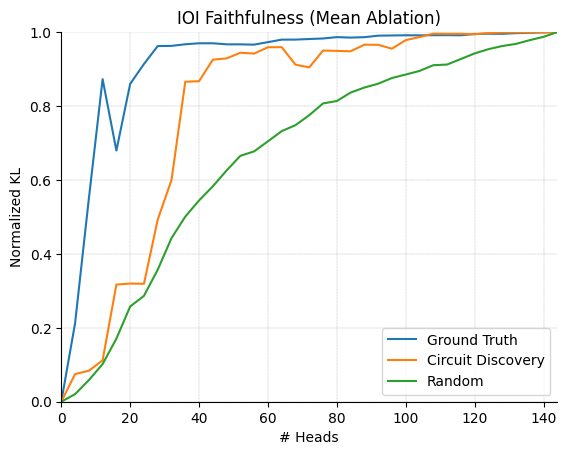

In [7]:
# a = task_eval.get_attn_head_freqs_over_dataset(N=N, return_freqs=True)

# %%
ground = task_eval.get_faithfulness_curve_over_data(N=20, attn_head_freq_n=10, faithfulness_intervals=30, rand=False, ioi_ground=True, task='ioi')
base = task_eval.get_faithfulness_curve_over_data(N=20, attn_head_freq_n=10, faithfulness_intervals=30, rand=False, ioi_ground=False, task='ioi')

radd = []
for _ in trange(20):
    radd.append(task_eval.get_faithfulness_curve_over_data(N=20, attn_head_freq_n=10, faithfulness_intervals=30, rand=True, ioi_ground=False, visualize=False))


# %%
big_rad = {}
for rad in radd:
    for k, v in rad.items():
        if k not in big_rad:
            big_rad[k] = 0
        big_rad[k] += v

for k in big_rad:
    big_rad[k] /= 20

rad = big_rad

# %%
plt.plot([float(k) for k in ground.keys()], ground.values(), label="Ground Truth")
plt.plot([float(k) for k in rad.keys()], base.values(), label="Circuit Discovery")
plt.plot([float(k) for k in base.keys()], rad.values(), label="Random")
plt.legend()
plt.grid(True)
plt.grid(color='gray', linestyle='--', linewidth=0.2)
plt.title("IOI Faithfulness (Mean Ablation)")
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.margins(0)
plt.ylabel("Normalized KL")
plt.xlabel("# Heads")
# ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
plt.show()

In [9]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=list(ground.keys()), y=list(ground.values()),
                         mode='lines+markers',
                         name='Ground Truth',
                         line=dict(color='blue', width=2),
                         marker=dict(size=8, symbol='circle', color='blue')))

fig.add_trace(go.Scatter(x=list(rad.keys()), y=list(base.values()),
                         mode='lines+markers',
                         name='Circuit Discovery',
                         line=dict(color='red', width=2),
                         marker=dict(size=8, symbol='square', color='red')))

fig.add_trace(go.Scatter(x=list(base.keys()), y=list(rad.values()),
                         mode='lines+markers',
                         name='Random',
                         line=dict(color='green', width=2),
                         marker=dict(size=8, symbol='triangle-up', color='green')))

fig.update_layout(
    title='IOI Faithfulness (Mean Ablation)',
    xaxis=dict(title='# Heads', showgrid=False, zeroline=False, showline=True, linewidth=1, linecolor='black', mirror=True),
    yaxis=dict(title='Normalized KL', showgrid=False, zeroline=False, showline=True, linewidth=1, linecolor='black', mirror=True),
    font=dict(size=14),
    template='plotly_white',
    width=800,
    height=600,
    legend=dict(x=0.7, y=0.9, borderwidth=1, bordercolor='black', bgcolor='rgba(255, 255, 255, 0.8)'),
    plot_bgcolor='white',
    hovermode='x'
)

# fig.update_xaxes(tickvals=list(ground.keys()))

fig.show()

In [12]:
# %%

%load_ext autoreload
%autoreload 2


# %%
import torch
import time
import plotly.express as px
import matplotlib.pyplot as plt

from task_evaluation import TaskEvaluation
from data.ioi_dataset import gen_templated_prompts
from data.greater_than_dataset import generate_greater_than_dataset
from circuit_discovery import CircuitDiscovery, only_feature
from circuit_lens import CircuitComponent
from plotly_utils import *
from data.ioi_dataset import IOI_GROUND_TRUTH_HEADS
from data.greater_than_dataset import GT_GROUND_TRUTH_HEADS
from memory import get_gpu_memory
from sklearn import metrics
from tqdm import trange

from utils import get_attn_head_roc


# %%
torch.set_grad_enabled(False)
# %%


#dataset_prompts = gen_templated_prompts(template_idex=1, N=500)
dataset_prompts = generate_greater_than_dataset(N=100)


# %%

def component_filter(component: str):
    return component in [
        CircuitComponent.Z_FEATURE,
        CircuitComponent.MLP_FEATURE,
        CircuitComponent.ATTN_HEAD,
        CircuitComponent.UNEMBED,
        # CircuitComponent.UNEMBED_AT_TOKEN,
        CircuitComponent.EMBED,
        CircuitComponent.POS_EMBED,
        # CircuitComponent.BIAS_O,
        CircuitComponent.Z_SAE_ERROR,
        # CircuitComponent.Z_SAE_BIAS,
        # CircuitComponent.TRANSCODER_ERROR,
        # CircuitComponent.TRANSCODER_BIAS,
    ]


pass_based = True

passes = 5
node_contributors = 1
first_pass_minimal = True

sub_passes = 3
do_sub_pass = False
layer_thres = 9
minimal = True


num_greedy_passes = 20
k = 1
N = 30

thres = 4

def strategy(cd: CircuitDiscovery):
    if pass_based:
        for _ in range(passes):
            cd.add_greedy_pass(contributors_per_node=node_contributors, minimal=first_pass_minimal)

            if do_sub_pass:
                for _ in range(sub_passes):
                    cd.add_greedy_pass_against_all_existing_nodes(contributors_per_node=node_contributors, skip_z_features=True, layer_threshold=layer_thres, minimal=minimal)
    else:
        for _ in range(num_greedy_passes):
            cd.greedily_add_top_contributors(k=k, reciever_threshold=thres)



task_eval = TaskEvaluation(prompts=dataset_prompts, circuit_discovery_strategy=strategy, allowed_components_filter=component_filter)

cd = task_eval.get_circuit_discovery_for_prompt(20)
# f = task_eval.get_features_at_heads_over_dataset(N=30)
N = 100

attn_freqs = task_eval.get_attn_head_freqs_over_dataset(N=N, subtract_counter_factuals=False, return_freqs=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
torch.Size([100, 13]) torch.Size([100])


100%|██████████| 100/100 [02:45<00:00,  1.66s/it]


In [13]:
import plotly.graph_objects as go

def get_attn_head_roc(ground_truth, data, task_name, visualize=True, additional_title=""):
    fp, tp, thresh = metrics.roc_curve(ground_truth.flatten(), data.flatten())
    score = metrics.roc_auc_score(ground_truth.flatten(), data.flatten())

    if visualize:
        print("Score:", score)

        # Create the ROC curve with flat lines and vertical lines
        x_coords = []
        y_coords = []

        for i in range(len(fp)):
            x_coords.append(fp[i])
            y_coords.append(tp[i])

            if i < len(fp) - 1:
                x_coords.append(fp[i])
                y_coords.append(tp[i+1])
                x_coords.append(fp[i+1])
                y_coords.append(tp[i+1])

        fig = go.Figure()

        fig.add_trace(go.Scatter(x=x_coords, y=y_coords,
                                 mode='lines',
                                 name='ROC Curve',
                                 line=dict(color='blue', width=2)))

        fig.add_shape(type='line',
                      x0=0, y0=0, x1=1, y1=1,
                      line=dict(color='red', width=2, dash='dash'),
                      name='Random Guess')

        fig.update_layout(
            title=f"ROC Curve for {task_name} " + additional_title,
            xaxis=dict(title='False Positive Rate', showgrid=False, zeroline=False),
            yaxis=dict(title='True Positive Rate', showgrid=False, zeroline=False),
            font=dict(size=14),
            template='plotly_white',
            width=600,
            height=600,
            legend=dict(x=0.7, y=0.2, borderwidth=1, bordercolor='black', bgcolor='rgba(255, 255, 255, 0.8)'),
            plot_bgcolor='white',
            hovermode='closest'
        )

        fig.update_xaxes(range=[0, 1.01])
        fig.update_yaxes(range=[0, 1.01])

        fig.show()

    return score, fp, tp, thresh

In [15]:
# IOI_GROUND_TRUTH_DATA = torch.load("data/ioi_ground_truth.pt")

# IOI_GROUND_TRUTH_HEADS = torch.zeros(12, 12)

# for layer, head in IOI_GROUND_TRUTH_DATA:
#     IOI_GROUND_TRUTH_HEADS[layer, head] = 1

# ground_truth = IOI_GROUND_TRUTH_HEADS.flatten()

GT_GROUND_TRUTH_DATA = torch.load("data/gt_ground_truth.pt")

GT_GROUND_TRUTH_HEADS = torch.zeros(12, 12)

for layer, head in GT_GROUND_TRUTH_DATA:
    GT_GROUND_TRUTH_HEADS[layer, head] = 1

ground_truth = GT_GROUND_TRUTH_HEADS.flatten()

# fp, tp, thresh = get_attn_head_roc(ground_truth, a.flatten().softmax(dim=-1), "IOI", visualize=True, additional_title="(No Counterfactuals)")
score, _, _, _ = get_attn_head_roc(ground_truth, attn_freqs.flatten().softmax(dim=-1), "GT", visualize=True, additional_title="(No Counterfactuals)")

Score: 0.8592592592592592


# Labelling IOI

How are we going to do this?
* We will work from the bottom up (starting at bottom nodes of our graph and moving onto connected components).
* Get feature families for each component. 
* Get max-activating examples for each feature family.
* Get token contributions for these max-activating examples - combine this into one prompt.
* Get the max-activating examples/tokens on IOI specific inputs, as well as token contributions.
* Provide a description of the IOI task in the prompt. 
* Provide the feature interpretation of every component feeding in to our current component.
* Get IOI-specific interpretation of component.

Baseline:
* One circuit at a time, same process. 


Extensions (not for now):
* Feature co-occurrences - not only what our component is doing, but how it passes information between nodes.

In [1]:
# Get feature families for each component

from autointerpretability import *

cp = get_circuit_prediction(task='ioi', N=20)

from collections import Counter, defaultdict

def get_top_k_feature_tuples_for_component(co_occurrence_dict, component_str, k=5):
    # Parse the component string to get the appropriate tuple key
    if component_str.startswith("MLP"):
        layer = int(component_str[3:])
        component = ('mlp_feature', layer)
    elif component_str.startswith("L") and "H" in component_str:
        layer, head = map(int, component_str[1:].split("H"))
        component = ('attn_head', layer, head)
    else:
        raise ValueError(f"Invalid component format: {component_str}")

    # Use a Counter to count the occurrences of each tuple
    global_counter = Counter()

    # Iterate through the co-occurrence dictionary
    for comp_pair, co_occurrences in co_occurrence_dict.items():
        comp1, comp2 = comp_pair

        if comp1 == component or comp2 == component:
            for feature_tuple in co_occurrences:
                global_counter[(comp_pair, feature_tuple)] += 1

    # Get the top-k tuples by count
    top_k_tuples = global_counter.most_common(k)

    # Create a dictionary to store the results
    top_k_dict = defaultdict(dict)
    
    for (comp_pair, feature_tuple), count in top_k_tuples:
        top_k_dict[comp_pair][feature_tuple] = count

    return top_k_dict

/Users/charlesoneill/miniconda3/envs/anu/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer
Loaded pretrained model gpt2-small into HookedTransformer

Loading SAEs...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 12/12 [00:08<00:00,  1.37it/s]



Loading Transcoders...


100%|██████████| 20/20 [00:48<00:00,  2.42s/it]


In [2]:
features = list(set(cp.circuit_hypergraph['L2_H2']['features']))
features

[19042, 6510, 4559, 176, 5081]

In [3]:
model, z_saes, transcoders = get_model_encoders('cpu')

In [6]:
# Autoreload
%load_ext autoreload
%autoreload 2

from data.ioi_dataset import gen_templated_prompts
from aug_interp_prompts import main_aug_interp_prompt, main_aug_interp_prompt_v2
from openai_utils import gen_openai_completion, get_response
from autointerpretability import *
from discovery_strategies import (
    create_filter,
    create_simple_greedy_strategy,
    create_top_contributor_strategy,
)
from max_act_analysis import MaxActAnalysis

features = list(set(cp.circuit_hypergraph['L2_H2']['features']))

#feature = 19042
layer = 2
num_examples = 5000

strategy = create_simple_greedy_strategy(
    passes=1,
    node_contributors=1,
    minimal=True,
)


dataset_prompts = gen_templated_prompts(template_idex=1, N=500)
prompts = [x['text'] + x['correct'] for x in dataset_prompts]
tokens = model.to_tokens(prompts)  # Assuming `model` is already defined
dataset_prompt_tokens = torch.tensor(tokens)

mini_examples_owt_overall = []
mini_examples_ioi_overall = []

for feature in features:

    analyze_owt = MaxActAnalysis(
        "attn", 
        layer, 
        feature, 
        num_sequences=num_examples, 
        batch_size=128, 
        strategy=strategy
    )
    mini_examples_owt = analyze_owt.get_context_referenced_prompts_for_range(0, 5)
    mini_examples_owt_overall.append(mini_examples_owt)

    # For Dataset Prompt Tokens
    analyze_prompts = MaxActAnalysis(
        "attn", 
        layer, 
        feature, 
        num_sequences=num_examples, 
        batch_size=128, 
        strategy=strategy, 
        token_dataset=dataset_prompt_tokens
    )
    mini_examples_ioi = analyze_prompts.get_context_referenced_prompts_for_range(0, 5)
    mini_examples_ioi_overall.append(mini_examples_ioi)

/var/folders/wg/cdt_cw_5265_z_gwnxlf0tv80000gn/T/ipykernel_8977/780314101.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset_prompt_tokens = torch.tensor(tokens)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


In [10]:
from jinja2 import Template
from typing import List, Tuple

def main_aug_interp_prompt_ioi(
    examples: List[str], examples_ioi: List[str], token_lr=("<<", ">>"), context_lr=("[[", "]]")
):
    tl, tr = token_lr
    cl, cr = context_lr

    template = Template(
        """
{# You are a meticulous AI researcher conducting an important investigation into a certain neuron in a language model. Your task is to analyze the neuron and provide an explanation that thoroughly encapsulates its behavior in the context of a specific task: Indirect Object Identification (IOI). Here's how you will complete this task: #}

You are a meticulous AI researcher conducting an important investigation into a certain neuron in a language model. This language model is trained to predict the text that will follow a given input. Your task is to figure out what sort of behavior this neuron is responsible for -- namely, when this neuron fires, what kind of predictions does this neuron promote in the context of the specific task of Indirect Object Identification (IOI)? Here's how you'll complete the task:

INPUT_DESCRIPTION: 
You will be given several examples of text that activate the neuron. First we'll provide the example text without any annotations, and then we'll provide the same text with annotations that show the specific tokens that caused the neuron to activate and context about why the neuron fired.

The specific token that the neuron activates on will be the last token in the sequence, and will appear between {{tl}} and {{tr}} (like {{tl}}this{{tr}}).  

Additionally, each sequence will have tokens enclosed between {{cl}} and {{cr}} (like {{cl}}this{{cr}}). From previous analysis, we know that these tokens form the context for why our neuron fires on the token enclosed in {{tl}} and {{tr}} (in addition to the value of the actual token itself). Note that we treat the group of tokens enclosed between {{cl}} and {{cr}} as the "context" for why the neuron fired.

We will provide both general examples and specific examples related to the task of Indirect Object Identification (IOI).

Task Description: A sentence containing indirect object identification (IOI) has an initial dependent clause, e.g. "When Mary and John went to the store", and a main clause, e.g. "John gave a bottle of milk to Mary". The initial clause introduces the indirect object (IO) "Mary" and the subject (S) "John". The main clause refers to the subject a second time, and in all our examples of IOI, the subject gives an object to the IO. The IOI task is to predict the final token in the sentence to be the IO. We use 'S1' and 'S2' to refer to the first and second occurrences of the subject, when we want to specify position.

Given these examples, complete the following steps.

OUTPUT_DESCRIPTION:

Step 1: Based on the general examples provided, write down observed patterns between the tokens that caused the neuron to activate (just the tokens enclosed in {{tl}} and {{tr}}).
Step 2: Based on the general examples provided, write down patterns you see in the context for why the neuron fired. (Remember, the "context" for an example is the group of tokens enclosed in {{cl}} and {{cr}}). Include any patterns in the relationships between different tokens in the context, and any patterns in the relationship between the context and the rest of the text.
Step 3: Write down several general shared features of the general text examples.
Step 4: Based on the IOI examples provided, write down observed patterns between the tokens that caused the neuron to activate (just the tokens enclosed in {{tl}} and {{tr}}).
Step 5: Based on the IOI examples provided, write down patterns you see in the context for why the neuron fired. (Remember, the "context" for an example is the group of tokens enclosed in {{cl}} and {{cr}}). Include any patterns in the relationships between different tokens in the context, and any patterns in the relationship between the context and the rest of the text.
Step 6: Write down several general shared features of the IOI text examples.
Step 7: Based on the patterns you found between the activating token and the relevant context in both general and IOI examples, write down your best explanation for what this neuron is responsible for. Propose your explanation in the following form: 
[EXPLANATION]: <your explanation>

Guidelines:
- Try to produce a final explanation that's both concise and general to the examples provided.
- Your explanation should be short: 1-2 sentences.
- Specifically address the neuron's role in the context of the IOI task, explaining its specific function in relation to predicting the indirect object.

INPUT:

General Examples:
{% for example in examples %}                         
EXAMPLE {{loop.index + 1}}:
- Base Text -
=================================================
{{example[0]}}
=================================================

- Annotated Text -
=================================================
{{example[1]}}
=================================================

{% endfor %}

IOI Task Examples:
{% for example in examples_ioi %}                         
EXAMPLE {{loop.index + 1}}:
- Base Text -
=================================================
{{example[0]}}
=================================================

- Annotated Text -
=================================================
{{example[1]}}
=================================================

{% endfor %}

OUTPUT:
                         
Step 1:
"""
    )

    return template.render(
        {"tl": tl, "tr": tr, "cl": cl, "cr": cr, "examples": examples, "examples_ioi": examples_ioi}
    )

In [12]:
p = main_aug_interp_prompt_ioi(mini_examples_owt_overall, mini_examples_ioi_overall)
print(p)




You are a meticulous AI researcher conducting an important investigation into a certain neuron in a language model. This language model is trained to predict the text that will follow a given input. Your task is to figure out what sort of behavior this neuron is responsible for -- namely, when this neuron fires, what kind of predictions does this neuron promote in the context of the specific task of Indirect Object Identification (IOI)? Here's how you'll complete the task:

INPUT_DESCRIPTION: 
You will be given several examples of text that activate the neuron. First we'll provide the example text without any annotations, and then we'll provide the same text with annotations that show the specific tokens that caused the neuron to activate and context about why the neuron fired.

The specific token that the neuron activates on will be the last token in the sequence, and will appear between << and >> (like <<this>>).  

Additionally, each sequence will have tokens enclosed between [[ 

In [14]:
interp = get_response(p)
print(interp)

In the general examples provided, the tokens that cause the neuron to activate are typically the beginning of a proper name or noun phrase (e.g., "R" in "Justin R", "Party" in "Justin Party", "people" in "Giving people", "C" in "William C", "A" in "William A", "Y" in "Matthew Y", "Mc" in "Matthew Mc", "Thomas" in "Ryan Thomas", and "Ker" in "Ryan Ker").

Step 2: In the context for why the neuron fires, tokens within the brackets "[[" and "]]" tend to be proper names or noun phrases similar to the activating tokens. They also often come before prepositions or conjunctions, suggesting this neuron relates to the prediction of names or parts of names in specific grammatical contexts. 

Step 3: In a shared feature of general text examples, this neuron seems to activate specifically around the final part of proper names, or completions of noun phrases. It's usually where a name or noun phrase immediately precedes a preposition, conjunction, or punctuation.

Step 4: In the IOI examples, the n

In [15]:
l2h2_interp = "Predicting conjunctions following the subject's name."

In [20]:
features = [x for x in list(set(cp.circuit_hypergraph['L0_H1']['features'])) if x!=-1]

#feature = 19042
layer = 0
num_examples = 5000

strategy = create_simple_greedy_strategy(
    passes=1,
    node_contributors=1,
    minimal=True,
)


dataset_prompts = gen_templated_prompts(template_idex=1, N=500)
prompts = [x['text'] + x['correct'] for x in dataset_prompts]
tokens = model.to_tokens(prompts)  # Assuming `model` is already defined
dataset_prompt_tokens = torch.tensor(tokens)

mini_examples_owt_overall = []
mini_examples_ioi_overall = []

for feature in features:

    analyze_owt = MaxActAnalysis(
        "attn", 
        layer, 
        feature, 
        num_sequences=num_examples, 
        batch_size=128, 
        strategy=strategy
    )
    mini_examples_owt = analyze_owt.get_context_referenced_prompts_for_range(0, 5)
    mini_examples_owt_overall.append(mini_examples_owt)

    # For Dataset Prompt Tokens
    analyze_prompts = MaxActAnalysis(
        "attn", 
        layer, 
        feature, 
        num_sequences=num_examples, 
        batch_size=128, 
        strategy=strategy, 
        token_dataset=dataset_prompt_tokens
    )
    mini_examples_ioi = analyze_prompts.get_context_referenced_prompts_for_range(0, 5)
    mini_examples_ioi_overall.append(mini_examples_ioi)

/var/folders/wg/cdt_cw_5265_z_gwnxlf0tv80000gn/T/ipykernel_8977/3545841595.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset_prompt_tokens = torch.tensor(tokens)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


In [25]:
# Convert list of lists into a single list
mini_examples_owt_overall = [item for sublist in mini_examples_owt_overall for item in sublist]
mini_examples_ioi_overall = [item for sublist in mini_examples_ioi_overall for item in sublist]

In [27]:
p = main_aug_interp_prompt_ioi(mini_examples_owt_overall, mini_examples_ioi_overall)
interp = get_response(p)
print(interp)

The tokens causing neuron activation are predominantly names such as "Christopher", "Michael", "John" etc. However, there are also non-name tokens that activate the neuron such as "<<" or ".", and common nouns like "bone".

Step 2: For the non-name tokens, there's typically no observable significant context that's provided (as nothing has been marked with [[ and ]] tags). For the proper names, the context appears to often be another proper name earlier in the sentence. For example, in "Then, Jamie and Christopher had a lot of fun at the station. Jamie gave a necklace to<< Christopher>>". The marked context is the first occurrence of the subject, "Jamie".

Step 3:
- The general examples frequently use proper names (especially male names) as the token to activate the neuron. 
- Sentences are often in the past tense and describe some form of action or event.
- Non-name examples often reflect tokens placed at the end of statements or inputs.

Step 4: Much like the general examples, the IOI

In [30]:
l0h1_interp = "Identifying the later appearance of the indirect object in a sentence structure where the indirect object is being given something."

In [32]:
features = [x for x in list(set(cp.circuit_hypergraph['L3_H0']['features'])) if x!=-1]

# #feature = 19042
layer = 3
num_examples = 5000

strategy = create_simple_greedy_strategy(
    passes=1,
    node_contributors=1,
    minimal=True,
)


dataset_prompts = gen_templated_prompts(template_idex=1, N=500)
prompts = [x['text'] + x['correct'] for x in dataset_prompts]
tokens = model.to_tokens(prompts)  # Assuming `model` is already defined
dataset_prompt_tokens = torch.tensor(tokens)

mini_examples_owt_overall = []
mini_examples_ioi_overall = []

for feature in features:

    analyze_owt = MaxActAnalysis(
        "attn", 
        layer, 
        feature, 
        num_sequences=num_examples, 
        batch_size=128, 
        strategy=strategy
    )
    mini_examples_owt = analyze_owt.get_context_referenced_prompts_for_range(0, 5)
    mini_examples_owt_overall.extend(mini_examples_owt)

    # For Dataset Prompt Tokens
    analyze_prompts = MaxActAnalysis(
        "attn", 
        layer, 
        feature, 
        num_sequences=num_examples, 
        batch_size=128, 
        strategy=strategy, 
        token_dataset=dataset_prompt_tokens
    )
    mini_examples_ioi = analyze_prompts.get_context_referenced_prompts_for_range(0, 5)
    mini_examples_ioi_overall.extend(mini_examples_ioi)

p = main_aug_interp_prompt_ioi(mini_examples_owt_overall, mini_examples_ioi_overall)
interp = get_response(p)
print(interp)

/var/folders/wg/cdt_cw_5265_z_gwnxlf0tv80000gn/T/ipykernel_8977/2252016215.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset_prompt_tokens = torch.tensor(tokens)
100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


The general examples seem to show that the tokens causing the neuron to fire are the last words of a sentence or clause. Often, these trigger tokens are nouns, specifically ones that have previously appeared in the text.

Step 2: Context tokens often immediately precede the trigger token with one or more words in between. These tokens usually form a small phrase or clause with the trigger token, sometimes giving additional information about the function or importance of the trigger token in the described scenario.

Step 3: General shared features of the text examples include: there is always a repeat of the trigger token within the text, the trigger token is frequently a noun, and the trigger token tends to appear at the end of a clause or sentence.

Step 4: For the IOI examples, the tokens causing the neuron to activate always refer to the subject (S1) or the indirect object (IO) in the task of indirect object identification (IOI). These tokens can be seen as placeholders indicating w

In [33]:
l3h0_interp = "Aids in flagging when and where the subject or indirect object from a prior clause reappears in the text."

In [34]:
features = [x for x in list(set(cp.circuit_hypergraph['L4_H11']['features'])) if x!=-1]
print(features)

# #feature = 19042
layer = 4
num_examples = 5000

strategy = create_simple_greedy_strategy(
    passes=1,
    node_contributors=1,
    minimal=True,
)


dataset_prompts = gen_templated_prompts(template_idex=1, N=500)
prompts = [x['text'] + x['correct'] for x in dataset_prompts]
tokens = model.to_tokens(prompts)  # Assuming `model` is already defined
dataset_prompt_tokens = torch.tensor(tokens)

mini_examples_owt_overall = []
mini_examples_ioi_overall = []

for feature in features:

    analyze_owt = MaxActAnalysis(
        "attn", 
        layer, 
        feature, 
        num_sequences=num_examples, 
        batch_size=128, 
        strategy=strategy
    )
    mini_examples_owt = analyze_owt.get_context_referenced_prompts_for_range(0, 5)
    mini_examples_owt_overall.extend(mini_examples_owt)

    # For Dataset Prompt Tokens
    analyze_prompts = MaxActAnalysis(
        "attn", 
        layer, 
        feature, 
        num_sequences=num_examples, 
        batch_size=128, 
        strategy=strategy, 
        token_dataset=dataset_prompt_tokens
    )
    mini_examples_ioi = analyze_prompts.get_context_referenced_prompts_for_range(0, 5)
    mini_examples_ioi_overall.extend(mini_examples_ioi)

p = main_aug_interp_prompt_ioi(mini_examples_owt_overall, mini_examples_ioi_overall)
interp = get_response(p)
print(interp)

/var/folders/wg/cdt_cw_5265_z_gwnxlf0tv80000gn/T/ipykernel_8977/4026547288.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset_prompt_tokens = torch.tensor(tokens)


[20359]


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


The neuron activates on determiners ("rightly", "hold", "observed", "are", "had") attached to the last token in the sequence.

Step 2: The context triggering neuron activation illustrates a co-occurrence pattern between a specific noun phrase (usually consisting of two proper nouns connected with "and") and the following determiner.

Step 3: The general shared features of the general text examples are that the sentence usually includes a pair of entities or characters expressed as "<Name_1> and <Name_2>", followed by a determiner that triggers the neuron activation.

Step 4: The neuron activates again on determiners ("had") attached to the last token in the sequence.

Step 5: The context triggers when there are two proper nouns connected with "and", followed by a determiner which then activates the neuron.

Step 6: The general shared features of the IOI text examples are that all sentences begin with "Then," and includes a pair of entities or characters expressed as "<Name_1> and <Name

In [39]:
l4h11_interp = """ 
Predicts a determiner that is following a structure of "<Name_1> and <Name_2>", signalling the association between two entities or characters and promoting predictions in the context of an action or state involving them. In the context of the IOI task, this neuron helps identify and predict an interaction between the subject and the indirect object.
"""

In [58]:
from jinja2 import Template
from typing import List, Tuple, Optional

def main_aug_interp_prompt_ioi(
    examples: List[str], examples_ioi: List[str], 
    token_lr=("<<", ">>"), context_lr=("[[", "]]")
):
    tl, tr = token_lr
    cl, cr = context_lr

    template = Template(
        """
{# You are a meticulous AI researcher conducting an important investigation into a certain neuron in a language model. Your task is to analyze the neuron and provide an explanation that thoroughly encapsulates its behavior in the context of a specific task: Indirect Object Identification (IOI). Here's how you will complete this task: #}

You are a meticulous AI researcher conducting an important investigation into a certain neuron in a language model. This language model is trained to predict the text that will follow a given input. Your task is to figure out what sort of behavior this neuron is responsible for -- namely, when this neuron fires, what kind of predictions does this neuron promote in the context of the specific task of Indirect Object Identification (IOI)? Here's how you'll complete the task:

INPUT_DESCRIPTION: 
You will be given several examples of text that activate the neuron. First we'll provide the example text without any annotations, and then we'll provide the same text with annotations that show the specific tokens that caused the neuron to activate and context about why the neuron fired.

The specific token that the neuron activates on will be the last token in the sequence, and will appear between {{tl}} and {{tr}} (like {{tl}}this{{tr}}).  

Additionally, each sequence will have tokens enclosed between {{cl}} and {{cr}} (like {{cl}}this{{cr}}). From previous analysis, we know that these tokens form the context for why our neuron fires on the token enclosed in {{tl}} and {{tr}} (in addition to the value of the actual token itself). Note that we treat the group of tokens enclosed between {{cl}} and {{cr}} as the "context" for why the neuron fired.

We will provide both general examples and specific examples related to the task of Indirect Object Identification (IOI).

Task Description: A sentence containing indirect object identification (IOI) has an initial dependent clause, e.g. "When Mary and John went to the store", and a main clause, e.g. "John gave a bottle of milk to Mary". The initial clause introduces the indirect object (IO) "Mary" and the subject (S) "John". The main clause refers to the subject a second time, and in all our examples of IOI, the subject gives an object to the IO. The IOI task is to predict the final token in the sentence to be the IO. We use 'S1' and 'S2' to refer to the first and second occurrences of the subject, when we want to specify position.

Given these examples, complete the following steps.

OUTPUT_DESCRIPTION:

Step 1: Based on the general examples provided, write down observed patterns between the tokens that caused the neuron to activate (just the tokens enclosed in {{tl}} and {{tr}}).
Step 2: Based on the general examples provided, write down patterns you see in the context for why the neuron fired. (Remember, the "context" for an example is the group of tokens enclosed in {{cl}} and {{cr}}). Include any patterns in the relationships between different tokens in the context, and any patterns in the relationship between the context and the rest of the text.
Step 3: Write down several general shared features of the general text examples.
Step 4: Based on the IOI examples provided, write down observed patterns between the tokens that caused the neuron to activate (just the tokens enclosed in {{tl}} and {{tr}}).
Step 5: Based on the IOI examples provided, write down patterns you see in the context for why the neuron fired. (Remember, the "context" for an example is the group of tokens enclosed in {{cl}} and {{cr}}). Include any patterns in the relationships between different tokens in the context, and any patterns in the relationship between the context and the rest of the text.
Step 6: Write down several general shared features of the IOI text examples.
Step 7: Based on the patterns you found between the activating token and the relevant context in both general and IOI examples, write down your best explanation for what this neuron is responsible for. Propose your explanation in the following form: 
[EXPLANATION]: <your explanation>

Guidelines:
- Try to produce a final explanation that's both concise and general to the examples provided.
- Your explanation should be short: 1-2 sentences.
- Specifically address the neuron's role in the context of the IOI task, explaining its specific function in relation to predicting the indirect object.
- If provided, incorporate the interpretation of the previous neurons into your explanation, considering how the current neuron processes and uses the information from these previous neurons.

INPUT:

General Examples:
{% for example in examples %}                         
EXAMPLE {{loop.index + 1}}:
- Base Text -
=================================================
{{example[0]}}
=================================================

- Annotated Text -
=================================================
{{example[1]}}
=================================================

{% endfor %}

IOI Task Examples:
{% for example in examples_ioi %}                         
EXAMPLE {{loop.index + 1}}:
- Base Text -
=================================================
{{example[0]}}
=================================================

- Annotated Text -
=================================================
{{example[1]}}
=================================================

{% endfor %}

OUTPUT:
                         
Step 1:
"""
    )

    return template.render(
        {"tl": tl, "tr": tr, "cl": cl, "cr": cr, "examples": examples, "examples_ioi": examples_ioi, "incoming_information": incoming_information}
    )

def main_aug_interp_prompt_ioi_incoming(
    examples: List[str], examples_ioi: List[str], 
    incoming_information: Optional[List[Tuple[str, str]]] = None, 
    token_lr=("<<", ">>"), context_lr=("[[", "]]")
):
    tl, tr = token_lr
    cl, cr = context_lr

    template = Template(
        """
{# You are a meticulous AI researcher conducting an important investigation into a certain neuron in a language model. Your task is to analyze the neuron and provide an explanation that thoroughly encapsulates its behavior in the context of a specific task: Indirect Object Identification (IOI). Here's how you will complete this task: #}

You are a meticulous AI researcher conducting an important investigation into a certain neuron in a language model. This language model is trained to predict the text that will follow a given input. Your task is to figure out what sort of behavior this neuron is responsible for -- namely, when this neuron fires, what kind of predictions does this neuron promote in the context of the specific task of Indirect Object Identification (IOI)? Here's how you'll complete the task:

INPUT_DESCRIPTION: 
You will be given several examples of text that activate the neuron. First we'll provide the example text without any annotations, and then we'll provide the same text with annotations that show the specific tokens that caused the neuron to activate and context about why the neuron fired.

The specific token that the neuron activates on will be the last token in the sequence, and will appear between {{tl}} and {{tr}} (like {{tl}}this{{tr}}).  

Additionally, each sequence will have tokens enclosed between {{cl}} and {{cr}} (like {{cl}}this{{cr}}). From previous analysis, we know that these tokens form the context for why our neuron fires on the token enclosed in {{tl}} and {{tr}} (in addition to the value of the actual token itself). Note that we treat the group of tokens enclosed between {{cl}} and {{cr}} as the "context" for why the neuron fired.

We will provide both general examples and specific examples related to the task of Indirect Object Identification (IOI).

Task Description: A sentence containing indirect object identification (IOI) has an initial dependent clause, e.g. "When Mary and John went to the store", and a main clause, e.g. "John gave a bottle of milk to Mary". The initial clause introduces the indirect object (IO) "Mary" and the subject (S) "John". The main clause refers to the subject a second time, and in all our examples of IOI, the subject gives an object to the IO. The IOI task is to predict the final token in the sentence to be the IO. We use 'S1' and 'S2' to refer to the first and second occurrences of the subject, when we want to specify position.

Previous Neuron Information:
You will also be provided with information about important previous neurons that feed into the current neuron. These neurons play a significant role in the IOI task and move information into the current neuron. The incoming information will be presented as a list of tuples, where each tuple contains the neuron's name and its interpretation in the context of the IOI task.

{% for neuron in incoming_information %}
Neuron {{neuron[0]}}:
- Interpretation in IOI context: {{neuron[1]}}

{% endfor %}

Use this incoming information to help interpret the current neuron's role, considering how it processes and uses the information from these previous neurons.

Given these examples, complete the following steps.

OUTPUT_DESCRIPTION:

Step 1: Based on the general examples provided, write down observed patterns between the tokens that caused the neuron to activate (just the tokens enclosed in {{tl}} and {{tr}}).
Step 2: Based on the general examples provided, write down patterns you see in the context for why the neuron fired. (Remember, the "context" for an example is the group of tokens enclosed in {{cl}} and {{cr}}). Include any patterns in the relationships between different tokens in the context, and any patterns in the relationship between the context and the rest of the text.
Step 3: Write down several general shared features of the general text examples.
Step 4: Based on the IOI examples provided, write down observed patterns between the tokens that caused the neuron to activate (just the tokens enclosed in {{tl}} and {{tr}}).
Step 5: Based on the IOI examples provided, write down patterns you see in the context for why the neuron fired. (Remember, the "context" for an example is the group of tokens enclosed in {{cl}} and {{cr}}). Include any patterns in the relationships between different tokens in the context, and any patterns in the relationship between the context and the rest of the text.
Step 6: Write down several general shared features of the IOI text examples.
Step 7: Based on the patterns you found between the activating token and the relevant context in both general and IOI examples, write down your best explanation for what this neuron is responsible for. Propose your explanation in the following form: 
[EXPLANATION]: <your explanation>

Guidelines:
- Try to produce a final explanation that's both concise and general to the examples provided.
- Your explanation should be short: 1-2 sentences.
- Specifically address the neuron's role in the context of the IOI task, explaining its specific function in relation to predicting the indirect object.
- If provided, incorporate the interpretation of the previous neurons into your explanation, considering how the current neuron processes and uses the information from these previous neurons.

INPUT:

General Examples:
{% for example in examples %}                         
EXAMPLE {{loop.index + 1}}:
- Base Text -
=================================================
{{example[0]}}
=================================================

- Annotated Text -
=================================================
{{example[1]}}
=================================================

{% endfor %}

IOI Task Examples:
{% for example in examples_ioi %}                         
EXAMPLE {{loop.index + 1}}:
- Base Text -
=================================================
{{example[0]}}
=================================================

- Annotated Text -
=================================================
{{example[1]}}
=================================================

{% endfor %}

OUTPUT:
                         
Step 1:
"""
    )

    return template.render(
        {"tl": tl, "tr": tr, "cl": cl, "cr": cr, "examples": examples, "examples_ioi": examples_ioi, "incoming_information": incoming_information}
    )

In [ ]:
features = [x for x in list(set(cp.circuit_hypergraph['L5_H5']['features'])) if x!=-1]
print(features)

# #feature = 19042
layer = 5
num_examples = 5000

strategy = create_simple_greedy_strategy(
    passes=1,
    node_contributors=1,
    minimal=True,
)


dataset_prompts = gen_templated_prompts(template_idex=1, N=500)
prompts = [x['text'] + x['correct'] for x in dataset_prompts]
tokens = model.to_tokens(prompts)  # Assuming `model` is already defined
dataset_prompt_tokens = torch.tensor(tokens)

mini_examples_owt_overall = []
mini_examples_ioi_overall = []

for feature in features:

    analyze_owt = MaxActAnalysis(
        "attn", 
        layer, 
        feature, 
        num_sequences=num_examples, 
        batch_size=128, 
        strategy=strategy
    )
    mini_examples_owt = analyze_owt.get_context_referenced_prompts_for_range(0, 5)
    mini_examples_owt_overall.extend(mini_examples_owt)

    # For Dataset Prompt Tokens
    analyze_prompts = MaxActAnalysis(
        "attn", 
        layer, 
        feature, 
        num_sequences=num_examples, 
        batch_size=128, 
        strategy=strategy, 
        token_dataset=dataset_prompt_tokens
    )
    mini_examples_ioi = analyze_prompts.get_context_referenced_prompts_for_range(0, 5)
    mini_examples_ioi_overall.extend(mini_examples_ioi)


incoming_information = [
    ("L2H2", l2h2_interp),
    ("L0H1", l0h1_interp),
    ("L3H0", l3h0_interp),
    ("L4H11", l4h11_interp),
]

p = main_aug_interp_prompt_ioi_incoming(mini_examples_owt_overall, mini_examples_ioi_overall, incoming_information)
interp = get_response(p)
print(interp)

In [65]:
l5h5_interp = "This neuron predicts the appearance of named entities, specifically indirect objects, influenced by a previous introduction of the same entity or entities in the text (especially when entities were linked with a conjunction), crucial in identifying these entities when they reappear in a later context."

In [69]:
features = [x for x in list(set(cp.circuit_hypergraph['L8_H6']['features'])) if x!=-1]
print(features)

# #feature = 19042
layer = 8
num_examples = 5000

strategy = create_simple_greedy_strategy(
    passes=1,
    node_contributors=1,
    minimal=True,
)


dataset_prompts = gen_templated_prompts(template_idex=1, N=500)
prompts = [x['text'] + x['correct'] for x in dataset_prompts]
tokens = model.to_tokens(prompts)  # Assuming `model` is already defined
dataset_prompt_tokens = torch.tensor(tokens)

mini_examples_owt_overall = []
mini_examples_ioi_overall = []

for feature in features:

    analyze_owt = MaxActAnalysis(
        "attn", 
        layer, 
        feature, 
        num_sequences=num_examples, 
        batch_size=128, 
        strategy=strategy
    )
    mini_examples_owt = analyze_owt.get_context_referenced_prompts_for_range(0, 5)
    mini_examples_owt_overall.extend(mini_examples_owt)

    # For Dataset Prompt Tokens
    analyze_prompts = MaxActAnalysis(
        "attn", 
        layer, 
        feature, 
        num_sequences=num_examples, 
        batch_size=128, 
        strategy=strategy, 
        token_dataset=dataset_prompt_tokens
    )
    mini_examples_ioi = analyze_prompts.get_context_referenced_prompts_for_range(0, 5)
    mini_examples_ioi_overall.extend(mini_examples_ioi)


incoming_information = [
    # ("L2H2", l2h2_interp),
    # ("L0H1", l0h1_interp),
    # ("L3H0", l3h0_interp),
    # ("L4H11", l4h11_interp),
    ("L5H5", l5h5_interp),
]

p = main_aug_interp_prompt_ioi_incoming(mini_examples_owt_overall, mini_examples_ioi_overall, incoming_information)
interp = get_response(p)
print(interp)

/var/folders/wg/cdt_cw_5265_z_gwnxlf0tv80000gn/T/ipykernel_8977/912588485.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset_prompt_tokens = torch.tensor(tokens)


[6424, 16513, 2623]


100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


The tokens that activate the neuron are mostly coordinating conjunctions ("and"), a few terminal markers like period and closing parenthesis, and in one instance, a preposition ("to").

Step 2: In all the general examples, the context responsible for the firing of the neuron includes named entities, linked together with the help of conjunction. These named entities are highlighted as a pair in most cases or individually with the pair forming the overall context. The named entities seem to be part of a group or set of entities being listed or described in the given text. A common pattern is either the entities are connected through a shared activity or attribute, or they are being enumerated or introduced for the first time in the context.

Step 3: A shared feature in the general text examples is the presence of a group or a pair of named entities in the context. These entities could be part of an enumeration, a description, or a narration involving these entities.

Step 4: The tokens t

In [79]:
l8h6_interp = """ 
This neuron is responsible for detecting a linking or coordinating structure ("and", "to") between multiple named entities when those entities have already been introduced, as determined by L5H5.
"""

In [ ]:
cp.circuit_hypergraph['L9_H9']['features']

In [ ]:
features = [x for x in list(set(cp.circuit_hypergraph['L9_H9']['features'])) if x!=-1]
print(features)

# #feature = 19042
layer = 9
num_examples = 2500

strategy = create_simple_greedy_strategy(
    passes=1,
    node_contributors=1,
    minimal=True,
)


dataset_prompts = gen_templated_prompts(template_idex=1, N=500)
prompts = [x['text'] + x['correct'] for x in dataset_prompts]
tokens = model.to_tokens(prompts)  # Assuming `model` is already defined
dataset_prompt_tokens = torch.tensor(tokens)

mini_examples_owt_overall = []
mini_examples_ioi_overall = []

for feature in features:
    try:

        analyze_owt = MaxActAnalysis(
            "attn", 
            layer, 
            feature, 
            num_sequences=num_examples, 
            batch_size=128, 
            strategy=strategy
        )
        mini_examples_owt = analyze_owt.get_context_referenced_prompts_for_range(0, 5)
        mini_examples_owt_overall.extend(mini_examples_owt)

        # For Dataset Prompt Tokens
        analyze_prompts = MaxActAnalysis(
            "attn", 
            layer, 
            feature, 
            num_sequences=num_examples, 
            batch_size=128, 
            strategy=strategy, 
            token_dataset=dataset_prompt_tokens
        )
        mini_examples_ioi = analyze_prompts.get_context_referenced_prompts_for_range(0, 5)
        mini_examples_ioi_overall.extend(mini_examples_ioi)
    
    except:
        print(f"Error with feature {feature}")

In [80]:
incoming_information = [
    # ("L2H2", l2h2_interp),
    # ("L0H1", l0h1_interp),
    # ("L3H0", l3h0_interp),
    # ("L4H11", l4h11_interp),
    #("L5H5", l5h5_interp),
    ("L8H6", l8h6_interp),
]

p = main_aug_interp_prompt_ioi_incoming(mini_examples_owt_overall, mini_examples_ioi_overall, incoming_information)
interp = get_response(p)
print(interp)

In the general examples, the neuron activates on a diverse set of tokens. These include function words ("to", "is", "at", "does", "up", ",", "of", ".", "�", "and", "(", ")"), names ("Emily", "Marilyn", "Chris", "Eric", "P", "Sarah", "Crystal", "Jacob"
, "Ellis", "Paul", "Carp", "t", "Josh", "Rita", "Alexander", "Allan") and other content words ("car", "pic", "Twitter", "com", "attention", "menace", ") ", "RT", "tagged", "call", "meet", "whether", "sell", "name").

Step 2: 
In most of the context provided, the neuron seems to pay attention to a combination of people's names (like "Emily", "Paul", "Eric", etc.), and function words ("to", "of", "at", etc). The name often appears in the context with some kind of action or possession (e.g., "Emily's image tagged in", "Paul gave a ring to", "Josh showed Mary"). The neuron also seems to capture various grammatical and semantic relations between tokens within the context.

Step 3: 
In general examples, the text is mostly composed of sentences 

In [81]:
print(p)




You are a meticulous AI researcher conducting an important investigation into a certain neuron in a language model. This language model is trained to predict the text that will follow a given input. Your task is to figure out what sort of behavior this neuron is responsible for -- namely, when this neuron fires, what kind of predictions does this neuron promote in the context of the specific task of Indirect Object Identification (IOI)? Here's how you'll complete the task:

INPUT_DESCRIPTION: 
You will be given several examples of text that activate the neuron. First we'll provide the example text without any annotations, and then we'll provide the same text with annotations that show the specific tokens that caused the neuron to activate and context about why the neuron fired.

The specific token that the neuron activates on will be the last token in the sequence, and will appear between << and >> (like <<this>>).  

Additionally, each sequence will have tokens enclosed between [[ 

In [82]:
features = [x for x in list(set(cp.circuit_hypergraph['L10_H7']['features'])) if x!=-1]
print(features)

# #feature = 19042
layer = 10
num_examples = 2500

strategy = create_simple_greedy_strategy(
    passes=1,
    node_contributors=1,
    minimal=True,
)


dataset_prompts = gen_templated_prompts(template_idex=1, N=500)
prompts = [x['text'] + x['correct'] for x in dataset_prompts]
tokens = model.to_tokens(prompts)  # Assuming `model` is already defined
dataset_prompt_tokens = torch.tensor(tokens)

mini_examples_owt_overall = []
mini_examples_ioi_overall = []

for feature in features:
    try:

        analyze_owt = MaxActAnalysis(
            "attn", 
            layer, 
            feature, 
            num_sequences=num_examples, 
            batch_size=128, 
            strategy=strategy
        )
        mini_examples_owt = analyze_owt.get_context_referenced_prompts_for_range(0, 5)
        mini_examples_owt_overall.extend(mini_examples_owt)

        # For Dataset Prompt Tokens
        analyze_prompts = MaxActAnalysis(
            "attn", 
            layer, 
            feature, 
            num_sequences=num_examples, 
            batch_size=128, 
            strategy=strategy, 
            token_dataset=dataset_prompt_tokens
        )
        mini_examples_ioi = analyze_prompts.get_context_referenced_prompts_for_range(0, 5)
        mini_examples_ioi_overall.extend(mini_examples_ioi)
    
    except:
        print(f"Error with feature {feature}")

/var/folders/wg/cdt_cw_5265_z_gwnxlf0tv80000gn/T/ipykernel_8977/1571428423.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset_prompt_tokens = torch.tensor(tokens)


[451, 1572, 22215, 24234, 23307, 6352, 8562, 2297]


100%|██████████| 5/5 [00:14<00:00,  2.87s/it]


In [83]:
incoming_information = [
    # ("L2H2", l2h2_interp),
    # ("L0H1", l0h1_interp),
    # ("L3H0", l3h0_interp),
    # ("L4H11", l4h11_interp),
    #("L5H5", l5h5_interp),
    ("L8H6", l8h6_interp),
]

p = main_aug_interp_prompt_ioi_incoming(mini_examples_owt_overall, mini_examples_ioi_overall, incoming_information)
interp = get_response(p)
print(interp)

The tokens causing the activation of this neuron are predominantly prepositions and determiners like "to", "the", "of", "@", "a", "for", "in", "and", ".", "," with a single instance of the pronoun "he". 

Step 2:
The context where the for the tokens resides is indicative of an interaction or a relation being established between entities, events, or ideas; these include relation of possession, location, or the performance of an action. Multiple instances include  verb-noun or verb-object constructions.

Step 3:
Many of the text examples contain information related to some activity or action undertaken by individuals or groups, with concrete consequences or outputs. The activities are varied, but often involve an item or concept being transferred, displayed, or impacted by an agent.

Step 4:
In all the IOI examples, the neuron activated on the token "to" or "gave".

Step 5:
The context in all of these examples involves an initial clause that introduces two named entities and a subsequent